In [1]:
!pip install -q transformers sentence-transformers pandas nltk
import pandas as pd
from sentence_transformers import SentenceTransformer, util
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [3]:

# Carregar o modelo pré-treinado de embeddings para código
model = SentenceTransformer('microsoft/codebert-base')

# Caminho do arquivo CSV de entrada
input_csv_path = "/content/sample_data/4_corrected_code_full_before_index.csv"
output_csv_path = "/content/sample_data/4_corrected_code_full_after_index_with_bleu.csv"

# Carregar o CSV
df = pd.read_csv(input_csv_path)

# Função para calcular a similaridade do cosseno ou retornar vazio se faltar código
def calculate_cosine_similarity(row):
    source_code = row['SourceCode']
    code_fix = row['Code Fix']

    if pd.isna(source_code) or pd.isna(code_fix):
        return ""

    embedding_1 = model.encode(source_code, convert_to_tensor=True)
    embedding_2 = model.encode(code_fix, convert_to_tensor=True)
    cosine_similarity = util.cos_sim(embedding_1, embedding_2)
    return round(cosine_similarity.item(), 4)

# Função para calcular o BLEU score
def calculate_bleu_score(row):
    source_code = row['SourceCode']
    code_fix = row['Code Fix']

    if pd.isna(source_code) or pd.isna(code_fix):
        return ""

    # Tokenizar o código (divide em palavras ou tokens)
    reference = [source_code.split()]  # Lista de referência
    candidate = code_fix.split()      # Código gerado

    # Calcular BLEU com suavização para pequenos textos
    smoothie = SmoothingFunction().method4
    bleu_score = sentence_bleu(reference, candidate, smoothing_function=smoothie)
    return round(bleu_score, 4)

# Criar novas colunas para os resultados
#df['CodeBERT_Cosine Similarity'] = df.apply(calculate_cosine_similarity, axis=1)
df['BLEU Score'] = df.apply(calculate_bleu_score, axis=1)

# Salvar o arquivo atualizado
df.to_csv(output_csv_path, index=False)

print(f"Arquivo atualizado salvo em: {output_csv_path}")


pytorch_model.bin:  82%|########2 | 409M/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Arquivo atualizado salvo em: /content/sample_data/4_corrected_code_full_after_index_with_bleu.csv


GRÁFICO

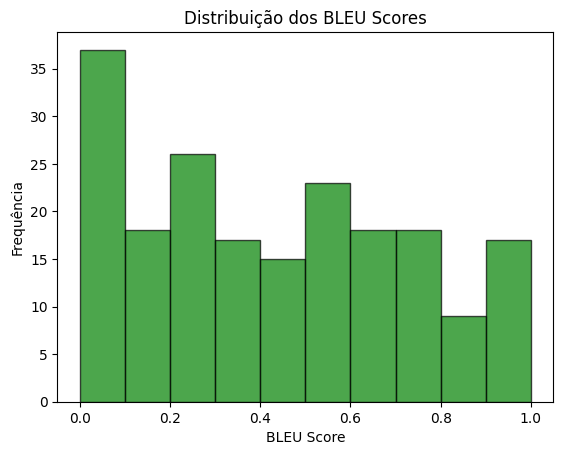

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Caminho do arquivo CSV atualizado
output_csv_path = "/content/sample_data/4_corrected_code_full_after_index_with_bleu.csv"

# Carregar o CSV com os resultados já calculados
df = pd.read_csv(output_csv_path)

# Gerar o histograma dos BLEU Scores
bleu_scores = df['BLEU Score'].dropna()  # Remove valores vazios
plt.hist(bleu_scores, bins=10, alpha=0.7, color='green', edgecolor='black')
plt.title("Distribuição dos BLEU Scores")
plt.xlabel("BLEU Score")
plt.ylabel("Frequência")
plt.show()

